[Hands on RL Policy Gradient](https://github.com/PacktPublishing/Hands-on-Reinforcement-Learning-with-PyTorch/blob/master/Section%204/4.3%20Policy%20Gradients%20REINFORCE.ipynb)<br>
[Policy Gradient Math](https://towardsdatascience.com/policy-gradients-in-reinforcement-learning-explained-ecec7df94245)<br>
[Vanilla Policy Gradient](https://spinningup.openai.com/en/latest/algorithms/vpg.html)

In [1]:
!pip install swig
!pip install gymnasium[box2d]

  Obtaining dependency information for swig from https://files.pythonhosted.org/packages/d0/ef/44fb7b4216530551460666286ec04424d34f4a25e8fba1cebe742a24e012/swig-4.2.1-py2.py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
    --------------------------------------- 0.0/2.6 MB 326.8 kB/s eta 0:00:08
   - -------------------------------------- 0.1/2.6 MB 525.1 kB/s eta 0:00:05
   --- ------------------------------------ 0.2/2.6 MB 1.1 MB/s eta 0:00:03
   ------- -------------------------------- 0.5/2.6 MB 2.0 MB/s eta 0:00:02
   --------- ------------------------------ 0.6/2.6 MB 2.0 MB/s eta 0:00:01
   ---------------- ----------------------- 1.0/2.6 MB 3.1 MB/s eta 0:00:01
   ------------------ --------------------- 1.2/2.6 MB 3.2 MB

In [2]:
import torch
from torch import cuda, device, distributions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torch.distributions import Categorical
import math

import gymnasium as gym
import os, random
from pathlib import Path
from collections import deque

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [3]:
env_id = "LunarLander-v2"
env = gym.make(env_id)#,render_mode="human")

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  8
Sample observation [ 0.8914208   0.32451877  3.906178    2.8913825  -1.5259206  -2.2869513
  0.9605599   0.90086377]


In [4]:
device = device("cuda:0" if cuda.is_available() else "cpu")

In [8]:
def calc_disc_return(r_t , gamma = 0.998):

    G_t = deque(maxlen = len(r_t))
    G_t.append(r_t[-1])

    for i in reversed(r_t[:-1]):
        disc = i + (gamma*G_t[0])
        G_t.appendleft(disc)

    return np.array(G_t)

class PolicyNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(PolicyNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return F.softmax(self.output(x),dim = 1)

In [9]:
hidden_layer = 64
gamma = 0.99
learning_rate = 0.001
episodes = 100_000

policy_net = PolicyNet(s_size, a_size, hidden_layer).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr = learning_rate)

In [10]:
epi_results = []
loss_logger = []
for epi in range(episodes):

    s = env.reset()[0]
    term , trunc = False, False
    rewards, states , actions = [], [], []
    win = 0

    while not any([term, trunc]):

        states.append(s)
        obs = torch.FloatTensor(np.expand_dims(s,0)).to(device)

        with torch.no_grad():
            p_vals = policy_net(obs)
            p_vals = torch.squeeze(p_vals)

        p_vals = p_vals.detach().cpu().numpy()
        a = np.random.choice(a_size, p=p_vals)

        s_, r, term ,trunc, _  = env.step(a)
        actions.append(a)
        rewards.append(r)
        s=np.copy(s_)

    state_t = torch.FloatTensor(states).to(device)
    action_t = torch.LongTensor(actions).to(device).view(-1,1)
    return_t = torch.FloatTensor(calc_disc_return(rewards, gamma)).to(device).view(-1,1)

    selected_action_prob = policy_net(state_t).gather(1, action_t)
    loss = torch.mean(-torch.log(selected_action_prob) * return_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epi_results.append(np.sum(rewards))
    loss_logger.append(loss.item())

    if epi%100==0:
        clear_output()
    if epi%10==0:
        print(f'epi:{epi:05d} reward:{np.sum(rewards):8.2f} loss:{loss:8.2f}')
    if np.mean(epi_results[-50:])>200:
        break

epi:10600 reward:  233.08 loss:   25.92
epi:10610 reward:   18.37 loss:   -7.28
epi:10620 reward:  208.91 loss:   25.08


In [22]:
len(epi_results)

10625

In [25]:
mean_results = [np.mean(epi_results[i:i+50]) for i in range(10625-49)]

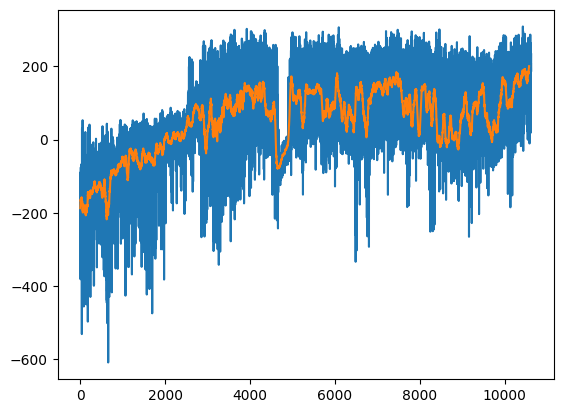

In [26]:
plt.plot(epi_results)
plt.plot(mean_results)

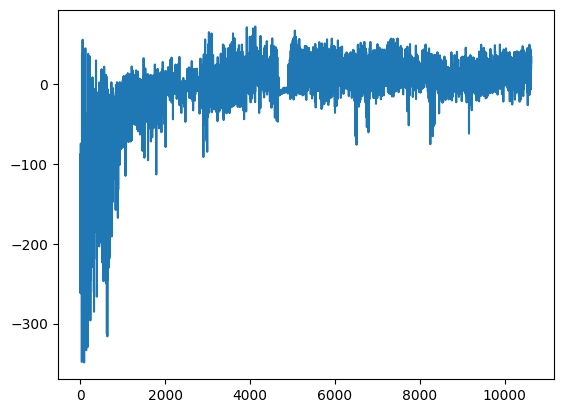

In [13]:
plt.plot(loss_logger)

In [18]:
eval_env = gym.make(env_id,render_mode="human")

for epi in range(10):

    s = eval_env.reset()[0]
    term = False
    trunc = False
    score = 0
    n=0
    while not any([term, trunc]):

        obs = torch.FloatTensor(np.expand_dims(s,0)).to(device)

        with torch.no_grad():
            p_vals = policy_net(obs)
            p_vals = torch.squeeze(p_vals)

        p_vals = p_vals.detach().cpu().numpy()
        #a = np.random.choice(a_size, p=p_vals)
        a = np.argmax(p_vals)
        s, r, term ,trunc , _  = eval_env.step(a)
        #s = np.copy(s_)
        #env.render()
        n+=1
        score+=r

    print(f'{epi = } result {score:4.2f}')
eval_env.close()

epi = 0 result 49.49
epi = 1 result 202.12
epi = 2 result 208.05
epi = 3 result 227.56
epi = 4 result 67.52
epi = 5 result 150.54
epi = 6 result 129.50
epi = 7 result 57.39
epi = 8 result 203.84
epi = 9 result 34.19
